In [2]:
#Import some necessary packages.
%matplotlib inline
import openmc
import os 
os.environ['OPENMC_CROSS_SECTIONS']='/home/dresden/endfb-viii.0-hdf5/cross_sections.xml'
import math
import numpy as np
from matplotlib import pyplot

# Define the fuel
uo2 = openmc.Material(name="uo2")
uo2.add_element("U", 1, percent_type="ao", enrichment=4.25)
uo2.add_element("O", 2, percent_type="ao")
uo2.set_density("g/cm3", 10.4)
uo2.temperature = 670 # 400 Celsisus


# Define the coolant
water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cm3", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
water.temperature = 533 # 260 Celsisus 

materials = openmc.Materials([uo2, water])

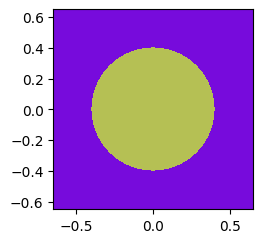

In [3]:
pitch = 1.3 # unit is cm
fuel_outer_radius = openmc.ZCylinder(r=0.4) 
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

# Regions
fuel_region = -fuel_outer_radius
water_region = +left & -right & +bottom & -top & +fuel_outer_radius

# Fill the regions with materials
fuel = openmc.Cell(name='fuel')
fuel.fill = uo2
fuel.region = fuel_region
moderator = openmc.Cell(name='moderator')
moderator.fill = water
moderator.region = water_region

# Universe
root_universe = openmc.Universe(cells=(fuel, moderator))

geometry = openmc.Geometry()
geometry.root_universe = root_universe

root_universe.plot(width = (pitch, pitch))

In [4]:
settings = openmc.Settings()

settings.temperature = {'method': 'interpolation'} 
settings.particles = 2000
settings.generations_per_batch = 10
settings.inactive = 5
settings.batches = 20

uo2.volume = math.pi * 0.4 ** 2

# Finally, don't forget to export to xml.
materials.export_to_xml()
geometry.export_to_xml()
settings.export_to_xml()

In [5]:
# Create equal-lethargy energies to put in filter
energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
e_filter = openmc.EnergyFilter(energies)

# Create tally with energy filter
tallies = openmc.Tallies()

tally = openmc.Tally(name='flux')
tally.filters = [e_filter]
tally.scores = ['flux']
tallies.append(tally)

# No filters here
fiss_rate = openmc.Tally(name='fiss_rate')
neu_fission = openmc.Tally(name='neu_fission')
fiss_rate.scores = ['fission']                   # Total fission reaction rate [fission/source]
neu_fission.scores = ['nu-fission']              # Total production of neutrons due to fission [neutrons/source]
tallies += (fiss_rate, neu_fission)

# Export to "tallies.xml"
tallies.export_to_xml()
model = openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

In [6]:
import openmc.deplete

chain = openmc.deplete.Chain.from_xml("./chain_casl_pwr.xml")  # This library is simplified.
operator = openmc.deplete.CoupledOperator(model, "./chain_casl_pwr.xml")

power = 174  # [W/cm]
time_steps = [30 * 24 * 60 * 60] * 6  # These stpes are not cumulative.

integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Nb95 from /home/dresden/endfb-viii.0-hdf5/neutron/Nb95.h5
 Reading Mo92 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo92.h5
 Reading Mo94 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo94.h5
 Reading Mo95 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo95.h5
 Reading Mo96 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo96.h5
 Reading Mo97 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo97.h5
 Reading Mo98 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo98.h5
 Reading Mo99 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo99.h5
 Reading Mo100 from /home/dresden/endfb-viii.0-hdf5/neutron/Mo100.h5


 Reading Tc99 from /home/dresden/endfb-viii.0-hdf5/neutron/Tc99.h5
 Reading Ru100 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru100.h5
 Reading Ru101 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru101.h5
 Reading Ru102 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru102.h5
 Reading Ru103 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru103.h5
 Reading Ru104 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru104.h5
 Reading Ru105 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru105.h5
 Reading Ru106 from /home/dresden/endfb-viii.0-hdf5/neutron/Ru106.h5
 Reading Rh103 from /home/dresden/endfb-viii.0-hdf5/neutron/Rh103.h5
 Reading Rh104 from /home/dresden/endfb-viii.0-hdf5/neutron/Rh104.h5
 Reading Rh105 from /home/dresden/endfb-viii.0-hdf5/neutron/Rh105.h5
 Reading Pd104 from /home/dresden/endfb-viii.0-hdf5/neutron/Pd104.h5
 Reading Pd105 from /home/dresden/endfb-viii.0-hdf5/neutron/Pd105.h5
 Reading Pd106 from /home/dresden/endfb-viii.0-hdf5/neutron/Pd106.h5
 Reading Pd107 from /home/dresden/en

 Reading I135 from /home/dresden/endfb-viii.0-hdf5/neutron/I135.h5
 Reading Xe128 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe128.h5
 Reading Xe130 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe130.h5
 Reading Xe131 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe131.h5
 Reading Xe132 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe132.h5
 Reading Xe133 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe133.h5


          2500K


 Reading Xe134 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe134.h5
 Reading Xe135 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe135.h5
 Reading Xe136 from /home/dresden/endfb-viii.0-hdf5/neutron/Xe136.h5
 Reading Cs133 from /home/dresden/endfb-viii.0-hdf5/neutron/Cs133.h5
 Reading Cs134 from /home/dresden/endfb-viii.0-hdf5/neutron/Cs134.h5
 Reading Cs135 from /home/dresden/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading Cs136 from /home/dresden/endfb-viii.0-hdf5/neutron/Cs136.h5
 Reading Cs137 from /home/dresden/endfb-viii.0-hdf5/neutron/Cs137.h5


          1200K
          2500K


 Reading Ba134 from /home/dresden/endfb-viii.0-hdf5/neutron/Ba134.h5
 Reading Ba137 from /home/dresden/endfb-viii.0-hdf5/neutron/Ba137.h5
 Reading Ba140 from /home/dresden/endfb-viii.0-hdf5/neutron/Ba140.h5
 Reading La139 from /home/dresden/endfb-viii.0-hdf5/neutron/La139.h5
 Reading La140 from /home/dresden/endfb-viii.0-hdf5/neutron/La140.h5
 Reading Ce140 from /home/dresden/endfb-viii.0-hdf5/neutron/Ce140.h5
 Reading Ce141 from /home/dresden/endfb-viii.0-hdf5/neutron/Ce141.h5
 Reading Ce142 from /home/dresden/endfb-viii.0-hdf5/neutron/Ce142.h5
 Reading Ce143 from /home/dresden/endfb-viii.0-hdf5/neutron/Ce143.h5
 Reading Ce144 from /home/dresden/endfb-viii.0-hdf5/neutron/Ce144.h5
 Reading Pr141 from /home/dresden/endfb-viii.0-hdf5/neutron/Pr141.h5
 Reading Pr142 from /home/dresden/endfb-viii.0-hdf5/neutron/Pr142.h5
 Reading Pr143 from /home/dresden/endfb-viii.0-hdf5/neutron/Pr143.h5
 Reading Nd142 from /home/dresden/endfb-viii.0-hdf5/neutron/Nd142.h5
 Reading Nd143 from /home/dresden/

          1200K
          2500K


 Reading Gd152 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd152.h5
 Reading Gd154 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from /home/dresden/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb159 from /home/dresden/endfb-viii.0-hdf5/neutron/Tb159.h5
 Reading Tb160 from /home/dresden/endfb-viii.0-hdf5/neutron/Tb160.h5
 Reading Tb161 from /home/dresden/endfb-viii.0-hdf5/neutron/Tb161.h5
 Reading Dy160 from /home/dresden/endfb-viii.0-hdf5/neutron/Dy160.h5
 Reading Dy161 from /home/dresden/endfb-viii.0-hdf5/neutron/Dy161.h5
 Reading Dy162 from /home/dresden/endfb-viii.0-hdf5/neutron/Dy162.h5
 Reading Dy163 from /home/dresden/

          1200K
          2500K


 Reading Ta182 from /home/dresden/endfb-viii.0-hdf5/neutron/Ta182.h5
 Reading Th230 from /home/dresden/endfb-viii.0-hdf5/neutron/Th230.h5
 Reading Th231 from /home/dresden/endfb-viii.0-hdf5/neutron/Th231.h5
 Reading Th232 from /home/dresden/endfb-viii.0-hdf5/neutron/Th232.h5
 Reading Th233 from /home/dresden/endfb-viii.0-hdf5/neutron/Th233.h5
 Reading Th234 from /home/dresden/endfb-viii.0-hdf5/neutron/Th234.h5
 Reading Pa231 from /home/dresden/endfb-viii.0-hdf5/neutron/Pa231.h5
 Reading Pa232 from /home/dresden/endfb-viii.0-hdf5/neutron/Pa232.h5
 Reading Pa233 from /home/dresden/endfb-viii.0-hdf5/neutron/Pa233.h5
 Reading U232 from /home/dresden/endfb-viii.0-hdf5/neutron/U232.h5
 Reading U233 from /home/dresden/endfb-viii.0-hdf5/neutron/U233.h5
 Reading U237 from /home/dresden/endfb-viii.0-hdf5/neutron/U237.h5
 Reading U239 from /home/dresden/endfb-viii.0-hdf5/neutron/U239.h5
 Reading Np236 from /home/dresden/endfb-viii.0-hdf5/neutron/Np236.h5
 Reading Np237 from /home/dresden/endfb-vi

[3.31984419e+05 0.00000000e+00 1.58305133e+05 2.57469408e+05
 0.00000000e+00 0.00000000e+00 2.06880210e+05 9.03323851e+04
 8.01859093e+04 1.75802255e+05 0.00000000e+00 0.00000000e+00
 2.08635624e+05 0.00000000e+00 2.21297852e+05 1.79900806e+06
 7.33343510e+04 0.00000000e+00 1.18602078e+06 5.16463584e+05
 2.01840917e+06 6.53092551e+05 5.52117910e+05 1.38153532e+06
 2.35131939e+05 1.13634953e+06 2.22720612e+06 1.81938440e+06
 1.32164580e+06 1.63614664e+05 1.47661153e+06 2.26488123e+06
 5.55651103e+05 2.35596080e+06 6.49023700e+05 5.53671906e+06
 6.45202198e+06 6.57759313e+05 8.86398382e+06 5.16101549e+06
 3.29365798e+06 8.77521425e+06 7.19554981e+06 1.41465792e+07
 9.21317956e+06 9.59774605e+06 1.90273820e+07 9.96596759e+06
 2.28392437e+07 2.12528776e+07 1.78953823e+07 2.12332776e+07
 2.43557424e+07 3.62648595e+07 2.85640662e+07 3.06758475e+07
 4.13168761e+07 6.28792460e+07 5.71553637e+07 3.18471261e+07
 5.47933288e+07 8.36996174e+07 7.94230985e+07 1.10913260e+08
 1.04463801e+08 1.695769

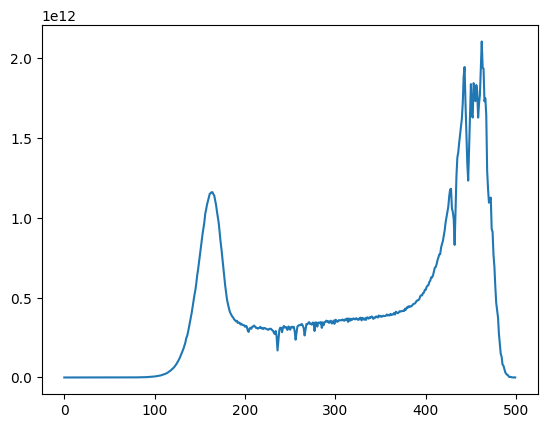

In [11]:
# To load data from the statepoint file in the EOL burnup step
sp = openmc.StatePoint('openmc_simulation_n6.h5')

# Get the mean values for each energy bin by using the mean attribute on the tally.
t = sp.get_tally(scores=['flux'])
flux = t.mean.ravel()        # [neutrons-cm/source]
flux_unc = t.std_dev.ravel()

# The unit of flux is [n/cm-src], we need to convert it into [n/cm2-s]
fiss = sp.get_tally(name='fiss_rate')
fiss_rate = fiss.mean.ravel()
neu = sp.get_tally(name='neu_fission')
neu_fission = neu.mean.ravel()
V = uo2.volume               # [cm^3]
P = 59.5                     # [J/sec], actually, I'm not sure.
Q = 3.2e-11                  # [J/fission]
nu = neu_fission/fiss_rate   # [neutrons/fission]
k = neu_fission              # [neutrons/source]
Flux = flux/V*(P*nu/(Q*k))  # [neutrons/cm^2-secle
print(Flux)
len(Flux)
import matplotlib.pyplot as plt

plt.plot(np.array(Flux))
from statistics import mean
print("The calculated mean of flux: ",mean(Flux))